# Dataset generation for the tasks
This file contains the code to generate the datasets for the tasks in the form of CSVs and pickles. The datasets are generated using the functions defined in this file.

In [136]:
# Import libraries used in the notebook
from automata_toolkit import regex_to_nfa # Converted to an automaton, used for measuring complexity
import random                             # For random data generation
import matplotlib.pyplot as plt           # Visualisation
from numpy.random import beta             # For data generation that adheres distributions
import re                                 # Regular expressions
import pandas as pd                       # Data table
import numpy as np                        # For supporting arrays

# For comparing the complexity of the tasks based on regexes
def regex_complexity(regex):
    nfa = regex_to_nfa.regex_to_nfa(regex)
    return len(nfa['states'])

# Generate random strings
def pad_string(string, alphabet):
    # Get size of padding from beta distribution
    padding_size_left, padding_size_right = beta(a=1, b=5, size=2)
    padding_size_left = round(padding_size_left * len(string))
    padding_size_right = round(padding_size_right * len(string))
    string = list(string)
    for _ in range(padding_size_left):
        string.insert(0, random.choice(alphabet))
    for _ in range(padding_size_right):
        string.append(random.choice(alphabet))
    return "".join(string)

# Modify string by mutating, deleting, inserting or swapping characters
def mutate(string, intensity, alphabet):
    # Draw amount of changes from beta distribution
    changes = round(beta(a=intensity, b=5) * len(string))
    if changes == 0:
        changes = 1
    # Choose randomly between mutation, deletion, insertion and swap
    core = list(string)
    for _ in range(changes):
        operation = random.choice(["mutate", "delete", "insert", "swap"])
        index = random.randint(0, len(core) - 1)
        if operation == "mutate":
            core[index] = random.choice(alphabet)
        elif operation == "delete":
            del core[index]
        elif operation == "insert":
            core.insert(index, random.choice(alphabet))
        elif operation == "swap":
            other_index = random.randint(0, len(core) - 1)
            core[index], core[other_index] = core[other_index], core[index]
    return "".join(core)

# Make a dataset with two classes: valid and invalid
def assemble_classification_dataset(generator, regex, name):
    # Try generating 10000 valid strings, checking for duplicates
    valid = []
    while len(valid) < 10000:
        string = generator(valid=True)
        if bool(re.search(regex, string)) == True:
            # Check if there is a duplicate already in the list
            if string not in valid:
                valid.append(string)

    invalid = []
    while len(invalid) < 10000:
        string = generator(valid=False)
        if bool(re.search(regex, string)) == False:
            # Check if there is a duplicate already in the list
            if string not in invalid:
                invalid.append(string)

    # Generate dataframe with two columns: "string" and "valid"
    df = pd.DataFrame({"string": valid + invalid, "valid": [True] * 10000 + [False] * 10000})
    # Save dataframe to CSV file
    df.to_csv(f"{name}.csv", index=False)
    print(df.head(5))
    print(df[df["valid"] == False].head(5))
    return df

# Make a dataset where output is a multilabel regression
def assemble_regression_dataset(generator, converter, name):
    # Try generating 10000 valid strings, checking for duplicates
    X = []
    y = []
    for _ in range(20000):
        lst = generator()
        # Convert lst to numpy array
        X.append(np.array(lst))
        y.append(np.array(converter(lst)))

    # Generate dataframe with two columns: "string" and "valid"
    df = pd.DataFrame({"X": X, "y": y})
    # Save dataframe with pickle
    df.to_pickle(f"{name}.pkl")
    print(df.head(5))
    return df

# Produce a single example of a time string
def generate_time_string(valid=True):
    alphabet = "0123456789APapMm: "
    hours = random.randint(1, 12)
    minutes = random.randint(0, 59)
    am_pm = random.choice(["AM", "PM"])
    # Pad minutes with 0 if needed
    if minutes < 10:
        minutes = f"0{minutes}"
    # Optional space between numbers and AM/PM
    if random.random() > 0.5:
        divider = " "
    else:
        divider = ""

    core = f"{hours}:{minutes}{divider}{am_pm}"

    if valid == False:
        core = mutate(string=core, intensity=3, alphabet=alphabet)
    return pad_string(core, alphabet = alphabet)

## The first two datasets: regex

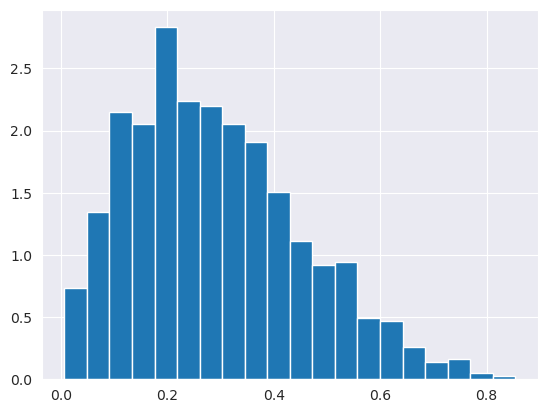

In [107]:
# Beta distribution https://en.wikipedia.org/wiki/Beta_distribution
# Used to introduce randomness in the amount of padding and mutations
random.seed(42)
values = beta(a=2, b=5, size=1000)

# Illustrate distribution
plt.hist(values, bins=20, density=True)
plt.show()
values = [round(value, 2) for value in values]

In [5]:
# Define regexes
time_regex = r"(0?[1-9]|1[012]):([0-5]\d)?\s?[APap][mM]" # Time string example: 12:00 AM, Time alphabet: [0-9APapMm:]
ipv6_regex = r"(([0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,7}:|([0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|([0-9a-fA-F]{1,4}:){1,5}(:[0-9a-fA-F]{1,4}){1,2}|([0-9a-fA-F]{1,4}:){1,4}(:[0-9a-fA-F]{1,4}){1,3}|([0-9a-fA-F]{1,4}:){1,3}(:[0-9a-fA-F]{1,4}){1,4}|([0-9a-fA-F]{1,4}:){1,2}(:[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:((:[0-9a-fA-F]{1,4}){1,6})|:((:[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(:[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(ffff(:0{1,4}){0,1}:){0,1}((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])|([0-9a-fA-F]{1,4}:){1,4}:((25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(25[0-5]|(2[0-4]|1{0,1}[0-9]){0,1}[0-9]))" # An example of IPv6 string: 2001:0db8:85a3:0000:0000:8a2e:0370:7334, IPv6 alphabet: [0-9a-fA-F:]

# Measure complexity of regexes
complexity = regex_complexity(time_regex)
print(f"Complexity of time regex: {complexity}")
complexity = regex_complexity(ipv6_regex)
print(f"Complexity of ipv6 regex: {complexity}")

Complexity of time regex: 66
Complexity of ipv6 regex: 1198


In [75]:
# Generate the first dataset with 10000 valid and 10000 invalid time strings
assemble_classification_dataset(generator=generate_time_string, regex=time_regex, name="time")

# Examine the produced dataset
# Get lengths of strings
lengths = [len(string) for string in df["string"]]
# Plot histogram

plt.hist(lengths, bins=20, density=True)
plt.show()

        string  valid
0  0657:03 AMp   True
1       1:59AM   True
2      38:14AM   True
3     A8:15 AM   True
4       2:04AM   True
            string  valid
10000    9:A2 PMMm  False
10001    a451461M0  False
10002     721:4AM0  False
10003  P8:40 P88Mp  False
10004    P:4p1MPm5  False


                                              string  valid
0         f2f8bb4:c7dc:dff8:30ed:8d6b:9a3e:c77:dfdbb   True
1  9:62e26c11a:c2fb:8467:acbd:d016:5026:acea:3b9e...   True
2  Eaa:DE2527:96d3:3513:9ac4:fbc2:60c0:fe14:9bd57...   True
3  :A6CFa14ab:da3d:6fb:2922:799a:ea7a:192:c3b1C37319   True
4  5DcBa2f4:b191:e0d5:bc0e:1f66:921a:2fac:2374e9E...   True
                                                  string  valid
10000  13A0db2cdcdb2:f86cbF:dc6c:db18:e3321E:DD964d1:...  False
10001  :B3Cfaa4:9297F186:788:b4de:de4:dddb:4e63Bb8D65...  False
10002  a86Aebb02361939:Dc548:64cc:247c4D1645:aeb:e0e7...  False
10003  2E7:de:8f:e6f:f21bbd82186e4d:c033c8f:675f5b0:3...  False
10004  40:99401459c3D:e549:cefd:f4c8dff6:Cbf1696168:E...  False


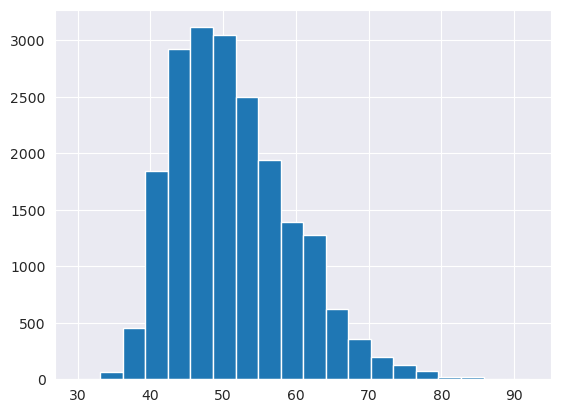

In [130]:
# Generate random ipv6 strings
def generate_ipv6_string(valid):
    alphabet = "0123456789abcdefABCDEF:"
    # Generate random ipv6 address
    core = ":".join([hex(random.randint(0, 65535))[2:] for _ in range(8)])
    if valid == False:
        core = mutate(string=core, intensity=2, alphabet=alphabet)
    return pad_string(core, alphabet = alphabet)

# Generate the second dataset with 10000 valid and 10000 invalid time strings
df = assemble_classification_dataset(generator=generate_ipv6_string, regex=ipv6_regex, name="ipv6")

# Examine the produced dataset
# Get lengths of strings
lengths = [len(string) for string in df["string"]]

# Plot histogram
plt.hist(lengths, bins=20)
plt.show()

## Third task dataset: Array of random numbers

In [146]:
# Generate arrays of numbers and find largest 5 in them
def generate_array():
    # Generate array of random length
    length = 5 + round(beta(a=2, b=5) * 10)
    lst = [random.randint(0, 1000)/1000 for _ in range(length)]
    return lst

# Perform calculation that will be inferred by the models
def find_ids_of_largest_and_smallest(array):
    # Sort array in descending order
    sorted_array = sorted(array, reverse=True)
    # Get ids of largest and smallest elements
    largest_ids = [array.index(value) for value in sorted_array[:1]]
    smallest_ids = [array.index(value) for value in sorted_array[-1:]]
    ids = largest_ids + smallest_ids
    # Convert ids to 0.0 - 1.0 range
    return [id/len(array) for id in ids]

# Show example
array = generate_array()
print(array)
print(find_ids_of_largest_and_smallest(array))

[0.256, 0.349, 0.416, 0.549, 0.192, 0.712]
[0.8333333333333334, 0.6666666666666666]


                                                   X  \
0  [0.057, 0.277, 0.758, 0.466, 0.518, 0.076, 0.469]   
1  [0.715, 0.005, 0.399, 0.535, 0.767, 0.018, 0.554]   
2  [0.761, 0.158, 0.204, 0.303, 0.222, 0.92, 0.44...   
3  [0.337, 0.63, 0.37, 0.662, 0.999, 0.198, 0.172...   
4  [0.726, 0.901, 0.601, 0.129, 0.743, 0.663, 0.2...   

                                           y  
0                  [0.2857142857142857, 0.0]  
1  [0.5714285714285714, 0.14285714285714285]  
2                             [0.625, 0.125]  
3   [0.4444444444444444, 0.6666666666666666]  
4                             [0.875, 0.375]  


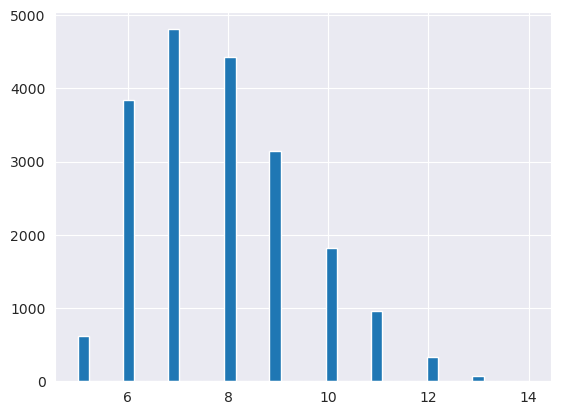

In [147]:
# Generate the third dataset
df = assemble_regression_dataset(generator=generate_array, name="lst", converter=find_ids_of_largest_and_smallest)

# Examine the produced dataset
# Get lengths of strings
lengths = [len(lst) for lst in df["X"]]

# Plot histogram
plt.hist(lengths, bins=40)
plt.show()